In [100]:
import os
import sys 
import glob
import pyproj
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp
# importing from one directory  up
# sys.path.insert(0, "../" )
# from .misc import round_to_hour, angular_difference, calculate_distance

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [101]:
# Chain
# TODO include for and aft viewing geometry in addition to mid, to obtain mutliple velocity vectors

# Inverse scatterometer velocity leakage
# FIXME apply smaller beampattern on data when resubmitting scatterometer NRCS as Sentinel-1 NRCS

In [102]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Iceland_20231107',
 'Scotland_20231109']

In [103]:
scenario = 'Morroco_20201103'
files = glob.glob(f"{data_dir+scenario}/*")

test = S1DopplerLeakage(
    filename=files,
    # era5_file='era5_winds/era5_wind_202011.nc',
    era5_directory= 'era5_winds/',
    scene_size=50_000,
    beam_pattern='phased_array' # ["sinc", "phased_array"]
    )

In [104]:
test.open_data()

# copy the data at this step
import copy
test_copy = copy.deepcopy(test)

test.querry_era5()
test.wdir_from_era5()
test.create_dataset()
test.create_beam_mask()
test.compute_scatt_eqv_backscatter()
test.compute_beam_pattern()
test.compute_Doppler_leakage()
# test.apply()

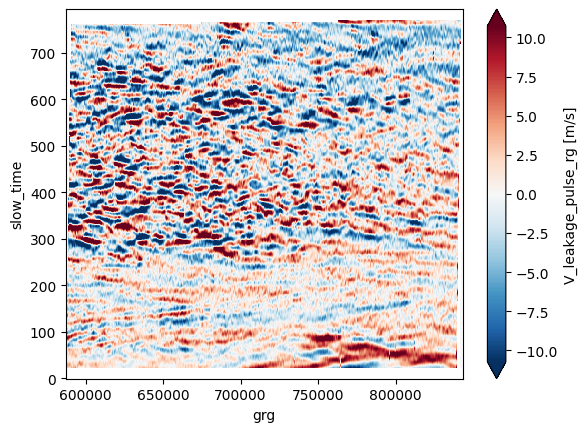

In [105]:
test.data.V_leakage_pulse_rg.T.plot(robust = True)
# test.subscenes.V_leakage_pulse_rg.T.plot(robust = True)

## Scatterometer backscatter direct estimate of velocity leakage

In [106]:
slow_time_upsamp = np.linspace(test.data.slow_time.min().values, test.data.slow_time.max().values, test_copy.S1_file.azimuth_time.count().values)
nrcs_scat_upsamp = test.data.nrcs_scat.interp(slow_time = slow_time_upsamp)
inc_scat_upsamp = test.data.inc_scatt_eqv.mean(dim='az_idx').interp(slow_time = slow_time_upsamp)

In [107]:
test_copy.S1_file['NRCS_VV'] = (['azimuth_time', 'ground_range'], nrcs_scat_upsamp.T.values)
test_copy.S1_file['inc'] = (['azimuth_time', 'ground_range'], inc_scat_upsamp.T.values)

In [108]:
test_copy.querry_era5()
test_copy.wdir_from_era5()
test_copy.create_dataset()
test_copy.create_beam_mask()
test_copy.compute_scatt_eqv_backscatter()
test_copy.compute_beam_pattern()
test_copy.compute_Doppler_leakage()

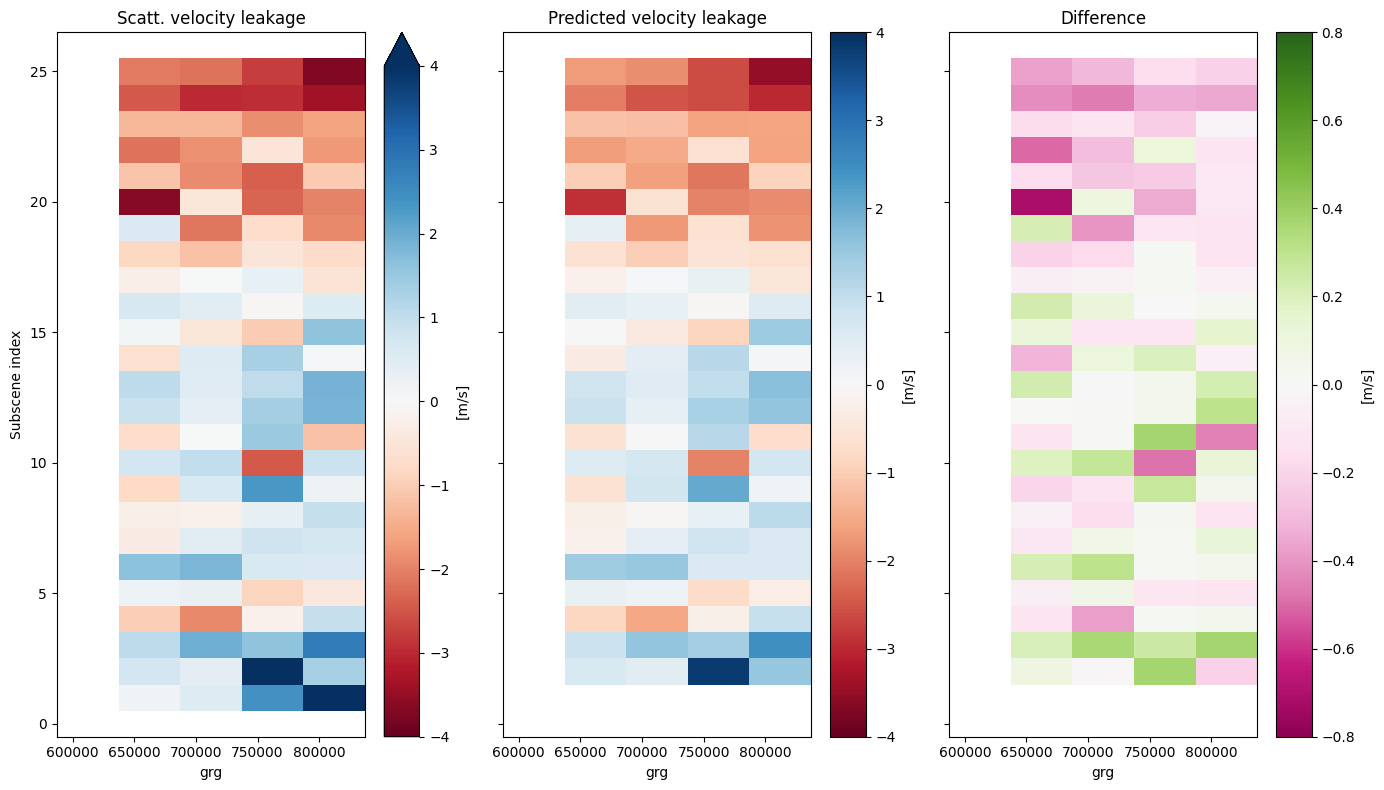

In [111]:
fig, axes = plt.subplots(1, 3, figsize=(14, 8), sharex=True, sharey=True)

vmin = -4
vmax = 4

test.subscenes.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[0], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
test_copy.subscenes.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[1], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
(test.subscenes.V_leakage_pulse_rg.T - test_copy.subscenes.V_leakage_pulse_rg.T).plot(robust = True, ax=axes[2], vmin=vmin/5, vmax=vmax/5,cmap='PiYG', cbar_kwargs={"label": "[m/s]"})

axes[0].set_ylabel('Subscene index')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].set_title('Scatt. velocity leakage')
axes[1].set_title('Predicted velocity leakage')
axes[2].set_title('Difference')
fig.tight_layout()

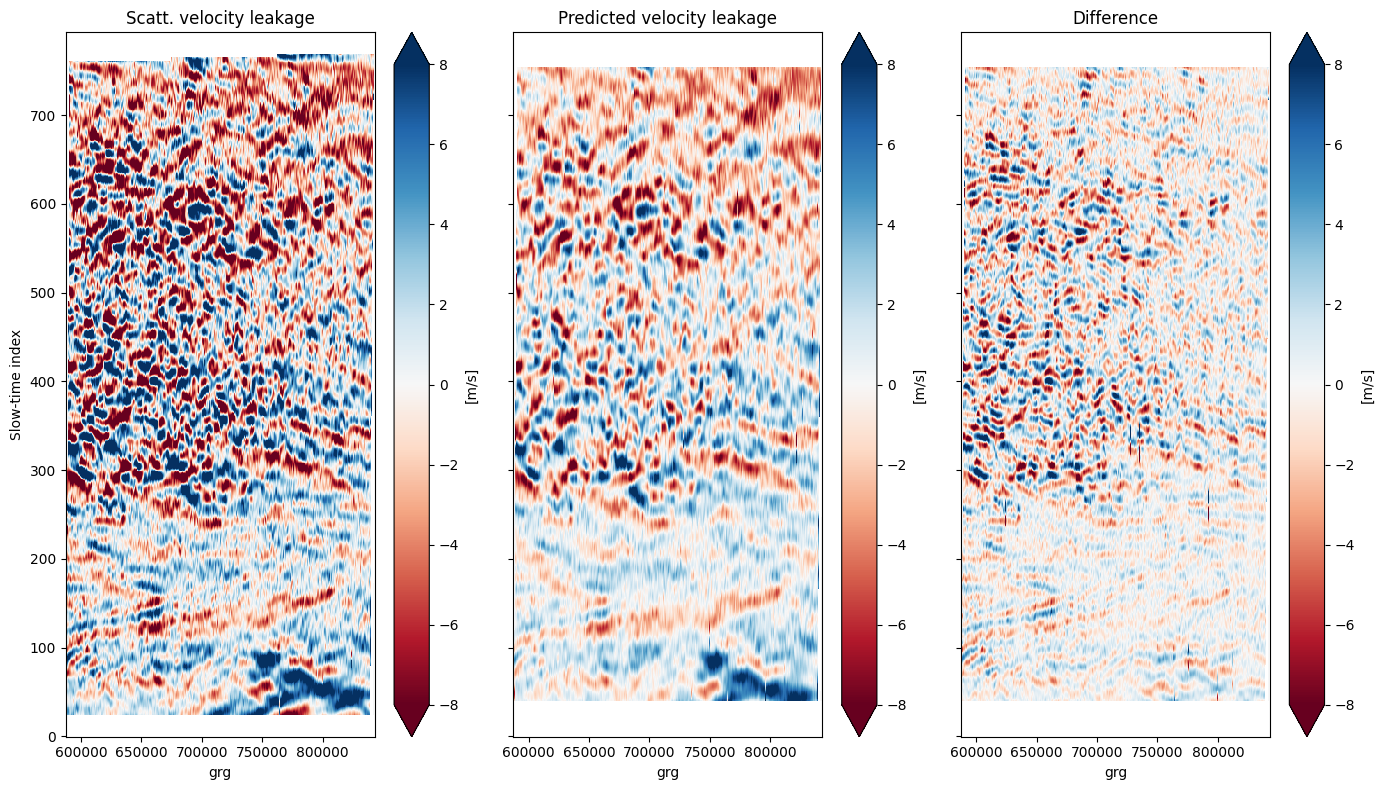

In [110]:
fig, axes = plt.subplots(1, 3, figsize=(14, 8), sharex=True, sharey=True)

vmin = -8
vmax = 8

test.data.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[0], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
test_copy.data.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[1], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
(test.data.V_leakage_pulse_rg.T - test_copy.data.V_leakage_pulse_rg.T).plot(robust = True, ax=axes[2], vmin=vmin, vmax=vmax,cmap='RdBu', cbar_kwargs={"label": "[m/s]"})

axes[0].set_ylabel('Slow-time index')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].set_title('Scatt. velocity leakage')
axes[1].set_title('Predicted velocity leakage')
axes[2].set_title('Difference')
fig.tight_layout()

In [113]:
nrcs_slope = np.nanpercentile((test.data.nrcs_scat.isel(slow_time = slice(0,-5-1)) - test.data.nrcs_scat.isel(slow_time = slice(5,-1))), 90)
nrcs_mean = np.nanpercentile(test.data.nrcs_scat, 50)#.plot(robust = True) #.plot(robust = True)#std()
sigma_azi_angle = test.data.az_angle_wrt_boresight.isel(slow_time = 50).sel(grg=700000, method='nearest').std()  # standard deviation of azimuth angle off borsight, approximately 0.023
vx_sat = 6800 # velocity satellite, m/s
inc = np.deg2rad(40) # TODO check if this is correct : azimuth angle relative to the velocity direction (incidence?)


V_leakage = nrcs_slope / nrcs_mean * sigma_azi_angle * vx_sat * np.sin(inc) # NOTE equation 3 from Rodriguez 2018
V_leakage.values

array(7.64267918)